In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
   width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [2]:
from gym_bitcoin_trader.gym_bitcoin_trader import clear
from multiprocessing.pool import ThreadPool
from gym_bitcoin_trader.gym_bitcoin_trader import GymBitcoinTrader
from utils.data_loader import get_bitcoin_data, datetime_fun, get_all_bitcoin_data
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql import Window
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option("max_columns",None)

# Inicializando contexto spark

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SEMMA').getOrCreate()

# Cargando la información en bruto

In [8]:
weekday_fn = np.vectorize(lambda a: a.weekday())
monthnumber_fn = np.vectorize(lambda a: a.month)
daymonth_fn = np.vectorize(lambda a: a.day)
def day_part_cond(x):
    if (x > 4) and (x <= 8):
        return 'early'
    elif (x > 8) and (x <= 12):
        return 'morning'
    elif (x > 12) and (x <= 16):
        return'noon'
    elif (x > 16) and (x <= 20) :
        return 'eve'
    elif (x > 20) and (x <= 24):
        return'night'
    elif (x <= 4):
        return'latenight'
day_part = np.vectorize(lambda a: day_part_cond(a.hour))

In [9]:
times, dataset,fields = get_all_bitcoin_data()

In [10]:
raw_dataframe = pd.DataFrame(dataset, columns=fields)
raw_dataframe["date"] = times
raw_dataframe["weekday"] = weekday_fn(times)
raw_dataframe["monthnumber"] = monthnumber_fn(times)
raw_dataframe["daymonth"] = daymonth_fn(times)
raw_dataframe["daypart"] = day_part(times)
fields_to_dummie = ["weekday","monthnumber","daymonth", "daypart"]
raw_dataframe = pd.get_dummies(raw_dataframe, columns=fields_to_dummie)
raw_dataframe["date"] = pd.Series(raw_dataframe['date'].dt.to_pydatetime(), dtype=object)

In [11]:
raw_dataframe["interval_btc"] = raw_dataframe["high_btc"]-raw_dataframe["low_btc"]
raw_dataframe["interval_eth"] = raw_dataframe["high_eth"]-raw_dataframe["low_eth"]

In [12]:
fields_to_regre = ['close_btc', 'high_btc', 'low_btc', 'volume_btc', 'volume_btc_usd',
       'close_eth', 'high_eth', 'low_eth', 'volume_eth', 'volume_eth_usd',
       'n_ratio_tweets', 'p_ratio_tweets', 'nl_ratio_tweets',
       'pr_no_neutral_tweets', 'avg_polarity', 'num_tweets'] + ["interval_btc", "interval_eth"]

In [13]:
def get_regression_function(lenght, X, Y):
    
    def get_regressions(ind):
        result = []
        start = max(0, ind-lenght)
        try:
            if ind != 1:
                reg = LinearRegression().fit(X[start:ind], Y[start:ind])
                result.append(float(reg.score(X[start:ind], Y[start:ind])))
                result.append(float(reg.coef_[0]))
                return result
            else:
                return None
        except:
            return None
    get_regressions_apply = np.vectorize(get_regressions)
    return get_regressions_apply

In [14]:
def get_regression_fields(dataframe, fields, lenghts):
    first_element_fn = np.vectorize(lambda a: 0.0 if a is None else a[0])
    second_element_fn = np.vectorize(lambda a: 0.0 if a is None else a[1])
    
    num_rows = raw_dataframe.shape[0]
    inds = np.arange(1,num_rows+1)
    X = inds.reshape(num_rows,1)
        
    for field_to_work in fields:
        Y = raw_dataframe[field_to_work]
        for lenght in lenghts:
            regr_values = get_regression_function(lenght, X, Y)(inds)
            result_field = "{}_regr{}".format(field_to_work, lenght)
            dataframe["{}_r2".format(result_field)] = first_element_fn(regr_values)
            dataframe["{}_m".format(result_field)] = second_element_fn(regr_values)
    return dataframe
    

In [15]:
new_dataframe = get_regression_fields(raw_dataframe, fields_to_regre,  [72,48,24,12, 6])

In [16]:
def getting_relative_grow(dataframe, fields):
    for field in fields:
        dataframe["{}_rel".format(field)] = dataframe[field]/ dataframe[field].shift(1)
    return dataframe

In [17]:
_ = getting_relative_grow(new_dataframe, fields_to_regre)

In [18]:
new_dataframe.to_csv("checkpoints/regression_variables.csv", index=False)

# Explorando variables

In [4]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 10)})

In [5]:
working_dataframe = pd.read_csv("checkpoints/regression_variables.csv")

In [8]:
working_dataframe.head()

close_btc     high_btc      low_btc  volume_btc  volume_btc_usd  \
0  2501.346680  2506.309977  2491.313395  162.346667   405580.635417   
1  2487.340007  2503.810059  2481.366699  160.456668   400407.572917   
2  2449.293294  2487.670003  2444.143311  342.700002   843546.718750   
3  2455.413330  2472.710042  2442.323324  312.586670   769288.447917   
4  2464.006755  2470.943278  2447.030029  226.220001   556701.822917   

    close_eth    high_eth     low_eth   volume_eth  volume_eth_usd  \
0  274.005005  279.065002  271.550003  2622.300049    7.225587e+05   
1  274.654999  274.745010  269.500000  3221.989990    8.746856e+05   
2  268.294998  274.705002  265.279999  7783.034912    2.092719e+06   
3  265.119995  269.300003  263.660004  5310.709961    1.416420e+06   
4  272.005005  272.369995  264.250000  4410.610107    1.184085e+06   

   n_ratio_tweets  p_ratio_tweets  nl_ratio_tweets  pr_no_neutral_tweets  \
0        0.055437        0.162047         0.782516              0.745098   
1        0.031447        0.210692         0.757862              0.870130   
2        0.040698        0.251453         0.707849              0.860697   
3        0.020000        0.188000         0.792000              0.903846   
4        0.027397        0.199391         0.773212              0.879195   

   avg_polarity  num_tweets                 date  weekday_0  weekday_1  \
0      0.067824       469.0  2017-07-01 11:00:00          0          0   
1      0.106131       636.0  2017-07-01 12:00:00          0          0   
2      0.109681       688.0  2017-07-01 13:00:00          0          0   
3      0.096408       750.0  2017-07-01 14:00:00          0          0   
4      0.100471       657.0  2017-07-01 15:00:00          0          0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  monthnumber_1  \
0          0          0          0          1          0              0   
1          0          0          0          1          0              0   
2          0          0          0          1          0              0   
3          0          0          0          1          0              0   
4          0          0          0          1          0              0   

   monthnumber_2  monthnumber_3  monthnumber_4  monthnumber_5  monthnumber_6  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   monthnumber_7  monthnumber_8  monthnumber_9  monthnumber_10  \
0              1              0              0               0   
1              1              0              0               0   
2              1              0              0               0   
3              1              0              0               0   
4              1              0              0               0   

   monthnumber_11  monthnumber_12  daymonth_1  daymonth_2  daymonth_3  \
0               0               0           1           0           0   
1               0               0           1           0           0   
2               0               0           1           0           0   
3               0               0           1           0           0   
4               0               0           1           0           0   

   daymonth_4  daymonth_5  daymonth_6  daymonth_7  daymonth_8  daymonth_9  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   daymonth_10  da

In [6]:
target = "target"

In [22]:
working_dataframe[target] =   np.where(working_dataframe["close_btc"].shift(-1)/working_dataframe["close_btc"] > 1,1,0)

In [23]:
working_dataframe["close_btc_rel"].min()

0.8897087283670903

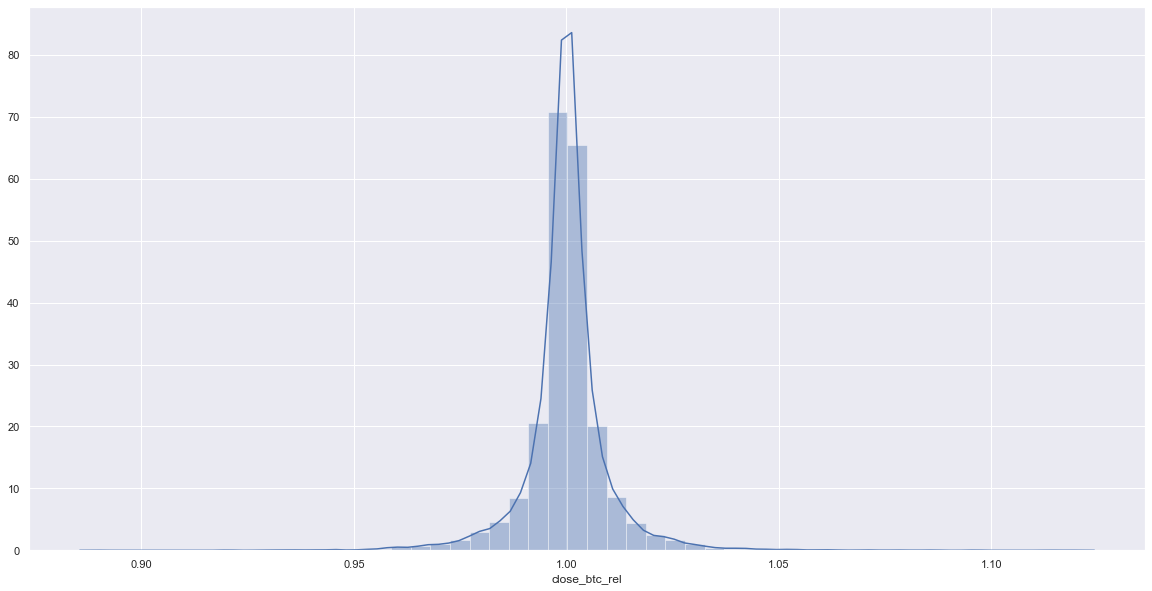

In [9]:
sns.distplot(working_dataframe["close_btc_rel"], )

In [24]:
working_dataframe[["target","close_btc"]].groupby(target).count()

close_btc
target           
0            8862
1            9391

In [25]:
working_dataframe = working_dataframe[:-1]

In [26]:
working_dataframe.drop("date", axis=1, inplace=True)

In [27]:
working_dataframe.fillna(0.0, inplace=True)

In [28]:
working_dataframe = working_dataframe.replace([np.inf, -np.inf], 1.0)

In [29]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(working_dataframe, test_size=0.2, random_state=1234)

In [30]:
features = np.array([ fld for fld in train.columns if fld not in ['close_btc_rel', 'low_btc_rel', 'high_btc_rel', target]])

In [31]:

from sklearn import ensemble

params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 20}
clf = RandomForestClassifier(**params)

NameError: name 'RandomForestClassifier' is not defined

In [32]:

from sklearn.ensemble import RandomForestClassifier
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [33]:

param_grid = {
    
            'n_estimators': [50, 80, 100,500],
            'max_depth': [5,10, 15]
}
select_rf_clf = RandomForestClassifier(random_state=10)

# we will 10-fold cross-validation
grid_clf = GridSearchCV(select_rf_clf,param_grid,cv=4)
grid_clf.fit(train[features], train[target])

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                                  

In [34]:
best_rf_clf = grid_clf.best_estimator_


In [35]:
best_rf_clf.score(test[features], test[target])

0.5456039441248973

In [45]:
best_rf_clf.score(test[features], test[target])

0.545877841687209

In [36]:
best_rf_clf.score(train[features], train[target])

0.6244777754948291

In [47]:
best_rf_clf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [50]:
clf.fit(train[features], train[target])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
clf.score(test[features], test[target])

0.5472473294987674

In [40]:
features[sorted_idx[-3:]]

array(['close_btc_rel', 'low_btc_rel', 'high_btc_rel'], dtype='<U30')

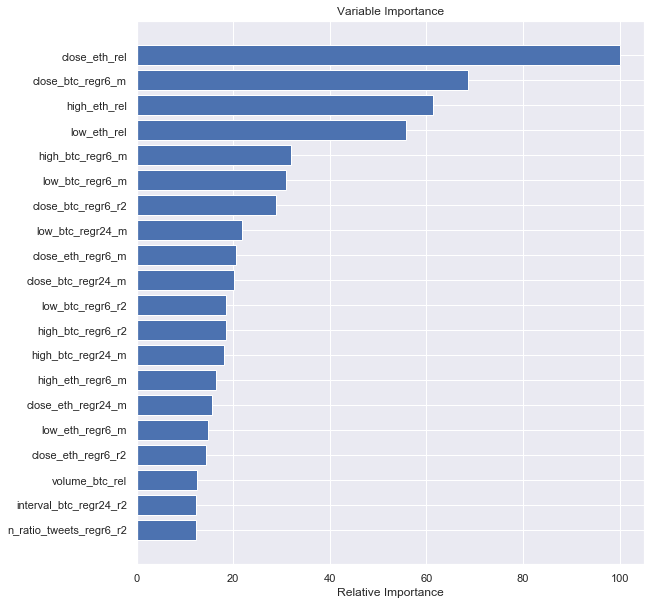

In [36]:
# Plot feature importance
feature_importance = best_rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

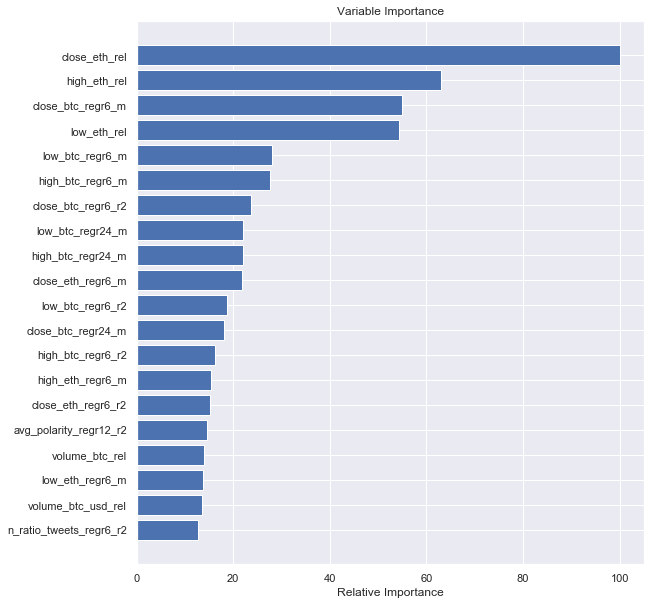

In [46]:
# Plot feature importance
feature_importance = best_rf_clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

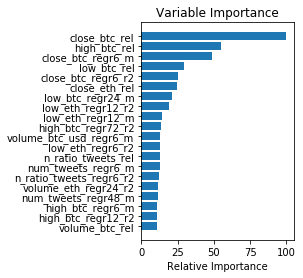

In [129]:
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)[-20:]
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, features[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [126]:
sorted_idx[:20]

array([ 0, 48, 50, 27, 28, 30, 31, 32, 33, 52, 36, 38, 39, 40, 41, 42, 43,
       44, 47, 37])

In [77]:
for fet in features:
    display(train[train[fet] == np.inf])

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

close_btc      high_btc       low_btc  volume_btc  volume_btc_usd  \
13143   3771.853353   3796.266683   3758.760010  403.456665    1.525290e+06   
3772   11833.263346  11846.633464  11754.976888  478.596670    5.650677e+06   

        close_eth    high_eth  low_eth   volume_eth  volume_eth_usd  \
13143  133.856664  136.793330   133.37  5039.636678    6.818276e+05   
3772   459.860006  460.730001   457.50  3038.223328    1.398659e+06   

       n_ratio_tweets  p_ratio_tweets  nl_ratio_tweets  pr_no_neutral_tweets  \
13143        0.026316        0.230994         0.742690              0.897727   
3772         0.027402        0.190080         0.782518              0.874003   

       avg_polarity  num_tweets  weekday_0  weekday_1  weekday_2  weekday_3  \
13143      0.114349       684.0          1          0          0          0   
3772       0.105246      2883.0          0          1          0          0   

       weekday_4  weekday_5  weekday_6  monthnumber_1  monthnumber_2  \
13143          0          0          0              0              0   
3772           0          0          0              0              0   

       monthnumber_3  monthnumber_4  monthnumber_5  monthnumber_6  \
13143              0              0              0              0   
3772               0              0              0              0   

       monthnumber_7  monthnumber_8  monthnumber_9  monthnumber_10  \
13143              0              0              0               0   
3772               0              0              0               0   

       monthnumber_11  monthnumber_12  daymonth_1  daymonth_2  daymonth_3  \
13143               0               1           0           0           0   
3772                0               1           0           0           0   

       daymonth_4  daymonth_5  daymonth_6  daymonth_7  daymonth_8  daymonth_9  \
13143           0           0           0           0           0           0   
3772            0           1           0           0           0           0   

       daymonth_10  daymonth_11  daymonth_12  daymonth_13  daymonth_14  \
13143            0            0            0            0            0   
3772             0            0            0            0            0   

       daymonth_15  daymonth_16  daymonth_17  daymonth_18  daymonth_19  \
13143            0            0            0            0            0   
3772             0            0            0            0            0   

       daymonth_20  daymonth_21  daymonth_22  daymonth_23  daymonth_24  \
13143            0            0            0            0            0   
3772             0            0            0            0            0   

       daymonth_25  daymonth_26  daymonth_27  daymonth_28  daymonth_29  \
13143            0            0            0            0            0   
3772             0            0            0            0            0   

       daymonth_30  daymonth_31  daypart_early  daypart_eve  \
13143            0            1              0            0   
3772             0            0              0            0   

       daypart_latenight  daypart_morning  daypart_night  daypart_noon  \
13143                  1                0              0             0   
3772                   0                0              0             1   

       close_btc_regr72_r2  close_btc_regr72_m  close_btc_regr48_r2  \
13143             0.109839            1.533303             0.302606   
3772              0.565697           10.229864             0.272398   

       close_btc_regr48_m  close_btc_regr24_r2  close_btc_regr24_m  \
13143           -2.056875             0.248700            2.039268   
3772             7.277695             0.811188           21.560622   

       close_btc_regr12_r2  close_btc_regr12_m  close_btc_regr6_r2  \
13143             0.024933           -0.700141            0.580641   
3772              0.580958           19.744458            0.968691   

       close_btc_regr6_m  

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []

Empty DataFrame
Columns: [close_btc, high_btc, low_btc, volume_btc, volume_btc_usd, close_eth, high_eth, low_eth, volume_eth, volume_eth_usd, n_ratio_tweets, p_ratio_tweets, nl_ratio_tweets, pr_no_neutral_tweets, avg_polarity, num_tweets, weekday_0, weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, weekday_6, monthnumber_1, monthnumber_2, monthnumber_3, monthnumber_4, monthnumber_5, monthnumber_6, monthnumber_7, monthnumber_8, monthnumber_9, monthnumber_10, monthnumber_11, monthnumber_12, daymonth_1, daymonth_2, daymonth_3, daymonth_4, daymonth_5, daymonth_6, daymonth_7, daymonth_8, daymonth_9, daymonth_10, daymonth_11, daymonth_12, daymonth_13, daymonth_14, daymonth_15, daymonth_16, daymonth_17, daymonth_18, daymonth_19, daymonth_20, daymonth_21, daymonth_22, daymonth_23, daymonth_24, daymonth_25, daymonth_26, daymonth_27, daymonth_28, daymonth_29, daymonth_30, daymonth_31, daypart_early, daypart_eve, daypart_latenight, daypart_morning, daypart_night, daypart_noon, close_btc_regr72_r2, close_btc_regr72_m, close_btc_regr48_r2, close_btc_regr48_m, close_btc_regr24_r2, close_btc_regr24_m, close_btc_regr12_r2, close_btc_regr12_m, close_btc_regr6_r2, close_btc_regr6_m, high_btc_regr72_r2, high_btc_regr72_m, high_btc_regr48_r2, high_btc_regr48_m, high_btc_regr24_r2, high_btc_regr24_m, high_btc_regr12_r2, high_btc_regr12_m, high_btc_regr6_r2, high_btc_regr6_m, low_btc_regr72_r2, low_btc_regr72_m, low_btc_regr48_r2, low_btc_regr48_m, low_btc_regr24_r2, low_btc_regr24_m, low_btc_regr12_r2, low_btc_regr12_m, ...]
Index: []